In [129]:
import csv
import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.signal

In [114]:
def read_data(filename):
    times = []   # sec
    flows = []   # L/sec
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                times.append(float(line[1].replace(",", "")))
                flows.append(np.sign(float(line[2]))*abs(float(line[2]) / 0.0538)**(4.0/7.0) / 60.0)
            if line[0] == "Sample #":
                start_fill = True
    return collections.namedtuple("TimesFlows", ["times", "flows"])(np.array(times), np.array(flows))

first = read_data("../sample-data/Sensirion_Philippe.csv")
normal = read_data("../sample-data/Sensirion_Philippe_normal.csv")
strong = read_data("../sample-data/Sensirion_Philippe_strongl.csv")

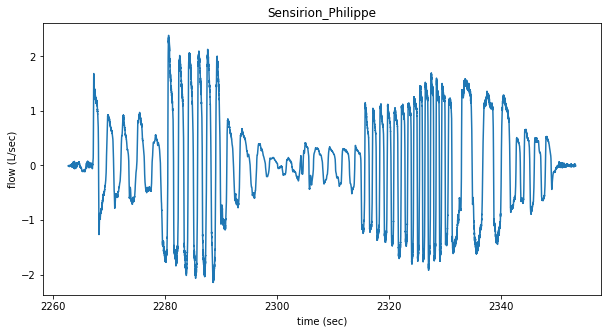

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.flows)
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe.png")

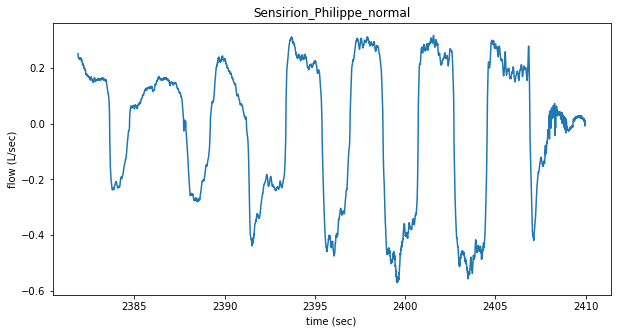

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.flows)
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_normal.png")

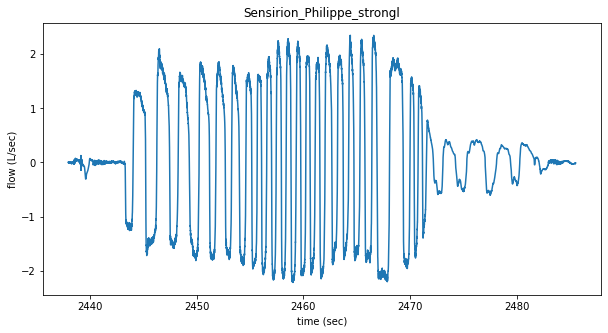

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.flows)
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_strongl.png")

In [157]:
def compute_volume(dataset):
    volumes = scipy.integrate.cumtrapz(dataset.flows, dataset.times)
    filtered = scipy.signal.sosfilt(scipy.signal.butter(4, 0.001, "highpass", output="sos"), volumes)
    return collections.namedtuple("TimesFlowsVolumes", ["times", "flows", "volumes", "filtered"])(
        dataset.times[:-1], dataset.flows[:-1], volumes, filtered)

first = compute_volume(first)
normal = compute_volume(normal)
strong = compute_volume(strong)

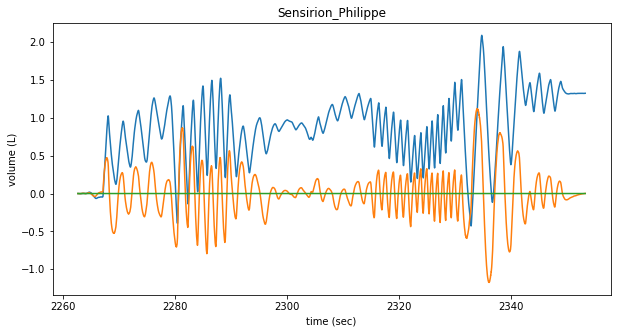

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.volumes)
ax.plot(first.times, first.filtered)
ax.plot(first.times, np.zeros(len(first.times)))
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe-volume.png")

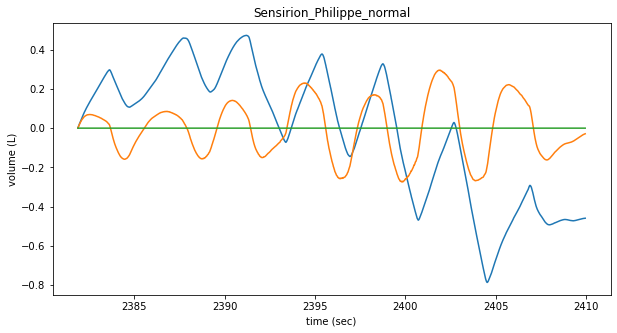

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.volumes)
ax.plot(normal.times, normal.filtered)
ax.plot(normal.times, np.zeros(len(normal.times)))
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe_normal-volume.png")

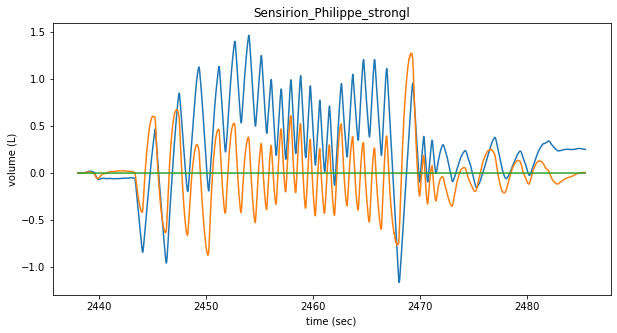

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.volumes)
ax.plot(strong.times, strong.filtered)
ax.plot(strong.times, np.zeros(len(strong.times)))
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("volume (L)")
fig.savefig("Sensirion_Philippe_strongl-volume.png")